<a href="https://colab.research.google.com/github/shahriarivari/Persian_sentiment_analysis/blob/main/Persian_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tokenizers
!pip install datasets
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


# BERT pre-training

## Initial imports

In [3]:
import os
import json
from tokenizers import BertWordPieceTokenizer
from transformers import BertModel, BertConfig
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from transformers import TrainerCallback
import logging

## Importing dataset from huggingface hub

In [4]:
# You should just change this part in order to download your
# parts of corpus.
indices = {
    "train": [5,
              #10, 20 , 110 , 120
              ],
    "test": [0,
             #1
             ]
}

N_FILES = {
    "train": 126,
    "test": 3
}
_BASE_URL = "https://huggingface.co/datasets/SLPL/naab/resolve/main/data/"
data_url = {
    "train": [_BASE_URL + "train-{:05d}-of-{:05d}.txt".format(x, N_FILES["train"]) for x in range(N_FILES["train"])],
    "test": [_BASE_URL + "test-{:05d}-of-{:05d}.txt".format(x, N_FILES["test"]) for x in range(N_FILES["test"])],
}
for index in indices['train']:
    assert index < N_FILES['train']
for index in indices['test']:
    assert index < N_FILES['test']
data_files = {
    "train": [data_url['train'][i] for i in indices['train']],
    "test": [data_url['test'][i] for i in indices['test']]
}

dataset = load_dataset('text', data_files=data_files, use_auth_token=False)
# Now you can use dataset for further processing
print(dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2479: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 18062599
    })
    test: Dataset({
        features: ['text'],
        num_rows: 4674154
    })
})


## Setting paths and file names

In [5]:
# Set your paths and file names
tokenizer_output_dir = "bert_tokenizer"
os.mkdir(tokenizer_output_dir)
pretrained_model_output_dir = "bert_pretrained_model"
os.mkdir(pretrained_model_output_dir)

In [ ]:
# def batch_iterator(dataset, batch_size=10000, mode="train"):
#     for i in range(0, len(dataset[mode]['text']), batch_size):
#         yield dataset[mode][i : i + batch_size]["text"]


In [ ]:
# vocab_size = 30_522
# min_frequency = 2
# max_length = 512
# special_tokens = ["[PAD]", "[MASK]", "[CLS]", "[SEP]", "[UNK]"]

# # Initialize the WordPiece tokenizer for BERT
# tokenizer = BertWordPieceTokenizer()

# tokenizer.train_from_iterator(batch_iterator(dataset),
#                               vocab_size=vocab_size,
#                               min_frequency=min_frequency,
#                               special_tokens=special_tokens,
#                               show_progress=True,)

# # enable truncation up to the maximum 512 tokens
# tokenizer.enable_truncation(max_length=max_length)

# # Save the trained tokenizer
# tokenizer.save_model(tokenizer_output_dir)

## Making files for trainging the tokenizer

In [ ]:
# Extract text data from the dataset
texts = dataset['train']['text']  # Assuming you have a 'text' column in your dataset

# Save the text data to a temporary file
temp_file_path = 'temp_dataset_file.txt'
with open(temp_file_path, 'w', encoding='utf-8') as file:
    for text in texts:
        file.write(text + '\n')

## Training a WordPiece Tokenizer

In [ ]:
# Training a WordPiece Tokenizer
files = [temp_file_path]
# Parameters for Tokenizer Training
vocab_size = 30_522
min_frequency = 2
max_length = 512
special_tokens = ["[PAD]", "[MASK]", "[CLS]", "[SEP]", "[UNK]"]

# Initialize the WordPiece tokenizer for BERT
tokenizer = BertWordPieceTokenizer()

# Train the tokenizer
tokenizer.train(
    files=files,
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    show_progress=True,
    special_tokens=special_tokens,
)

# enable truncation up to the maximum 512 tokens
tokenizer.enable_truncation(max_length=max_length)

# Save the trained tokenizer
# model_path = "pretrained_bert_tokenizer"
# # make the directory if not already there
# if not os.path.isdir(model_path):
#     os.mkdir(model_path)

# Save the trained tokenizer
tokenizer.save_model(tokenizer_output_dir)

# Clean up: Remove the temporary file
os.remove(temp_file_path)

In [ ]:
# import json
# # dumping some of the tokenizer config to config file,
# # including special tokens, whether
# # to lower case and the maximum sequence length

# with open(os.path.join(model_path, "config.json"), "w") as f:
#     tokenizer_cfg = {
#         "do_lower_case": True,
#         "unk_token": "[UNK]",
#         "sep_token": "[SEP]",
#         "pad_token": "[PAD]",
#         "cls_token": "[CLS]",
#         "mask_token": "[MASK]",
#         "model_max_length": max_length,
#         "max_len": max_length,
#     }
#     json.dump(tokenizer_cfg, f)

## tokenizing the dataset

In [6]:
vocab_size = 30_522
min_frequency = 2
max_length = 512
special_tokens = ["[PAD]", "[MASK]", "[CLS]", "[SEP]", "[UNK]"]

In [7]:
from transformers import BertTokenizerFast
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_output_dir)

In [8]:
max_sequence_length = max_length

# Define a custom tokenize function
def tokenize_function(example):
    # Ensure that the "text" field is a string
    if not isinstance(example["text"], str):
        raise TypeError("Input 'text' must be a string.")

    # Tokenize the text using BertTokenizerFast
    encoded = tokenizer(example["text"], truncation=True, padding='max_length',
                        return_special_tokens_mask=True,
                        max_length=max_sequence_length, return_tensors='pt')

    return {
        'input_ids': encoded['input_ids'].squeeze(),
        'attention_mask': encoded['attention_mask'].squeeze(),
    }

# Use the map function to tokenize the "train" split
tokenized_train_dataset = dataset['train'].select(list(range(10000))).map(tokenize_function, num_proc=4)
tokenized_test_dataset = dataset['test'].select(list(range(10000))).map(tokenize_function, num_proc=4)

Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

## Model Configuration

In [10]:
# Model Configuration
model_config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=768,  # Adjust as needed
    num_attention_heads=12,  # Adjust as needed
    num_hidden_layers=12,  # Adjust as needed
    max_position_embeddings=max_length,
)
# Model Initialization
model = BertForMaskedLM(config=model_config)

## Data Collator
Load your dataset using Hugging Face datasets library

In [11]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.2
    )

In [19]:
import torch
# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)  # You may need to adjust the learning rate


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
for batch in tokenized_train_dataset:
        # print(batch)
        inputs = data_collator([batch])
        # print(inputs)
        #     # Training loop
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        # optimizer.zero_grad()
        outputs = model(input_ids =input_ids,attention_mask = attention_mask)
        print(outputs)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

        break

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2820,  0.7212,  0.9412,  ..., -2.7075, -0.4672, -0.1476],
         [-0.4339,  0.3349, -0.4004,  ..., -1.4509,  0.8982, -1.1852],
         [-0.2342,  0.0643,  1.8047,  ..., -0.5239, -0.0175,  0.7308],
         ...,
         [-1.0026,  2.5093,  0.7070,  ..., -2.0075,  1.5163, -1.2048],
         [-1.4054,  1.6154,  1.3764,  ..., -0.6585,  0.2930, -0.3981],
         [-0.0804,  0.4379,  0.5183,  ..., -0.1718,  0.9813, -0.2222]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.5873, -0.3148,  0.5027, -0.3740, -0.5849, -0.0607, -0.4979,  0.4994,
         -0.2130,  0.1447,  0.1497,  0.3962, -0.5777,  0.3184,  0.4219, -0.5748,
         -0.3852,  0.2516, -0.0226, -0.3686, -0.0070,  0.0633,  0.1812,  0.1112,
          0.4156, -0.2669, -0.2038,  0.0107,  0.4424,  0.1563,  0.4903, -0.2875,
          0.5673, -0.4953,  0.1607,  0.6231,  0.3072, -0.2337, -0.2436,  0.6755,
         -0.825

## Training Arguments

In [12]:
# Training Arguments
training_args = TrainingArguments(
    output_dir=pretrained_model_output_dir, # output directory to where save model checkpoint
    overwrite_output_dir=True,
    num_train_epochs=10,                    # number of training epochs, feel free to tweak
    per_device_train_batch_size=10,         # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,          # accumulating the gradients before updating the weights
    per_device_eval_batch_size=64,          # evaluation batch size
    logging_steps=1000,                     # evaluate, log and save model checkpoints every 1000 step
    save_steps=1000,
    save_total_limit=3,                     # whether you don't have much space so you let only 3 model weights saved in the disk
    evaluation_strategy="steps",            # evaluate each `logging_steps` steps
    eval_steps=500,
)

## Trainer Initialization

In [13]:
# Trainer Initialization
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_test_dataset,
    data_collator = data_collator,
)

In [14]:
# Train the model
trainer.train()

# Save the final pre-trained model
trainer.save_model(os.path.join(pretrained_model_output_dir, "final_model"))

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TypeError: ignored

##Saving the model
First zip the model_dir then move it to google drive

In [ ]:
import shutil

source_dir = '/content/bert_pretrained_model'
output_filename = 'bert_pretrained_model'

# Create a Zip file
shutil.make_archive(output_filename, 'zip', source_dir)

'/content/bert_pretrained_model.zip'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Move the zip file to Google Drive
drive_path = '/content/drive/MyDrive/'
output_filename = '/content/bert_pretrained_model.zip'
shutil.move(output_filename, drive_path)

Mounted at /content/drive


'/content/drive/MyDrive/bert_pretrained_model.zip'

#Fine-Tuning BERT

##Import the dataset for SA task

In [36]:
!pip install hazm
!pip install stopwords_guilannlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 19.5 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=ab8455505811b8744390f1fc6bf09f5ac61330d72709af0ad7ba1fc65686e008
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

###Import libraries

In [37]:
# General
import numpy as np
import pandas as pd
import codecs

# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

###Import and analyze SA Dataset

In [38]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [39]:
x_test = test[0]
y_test = test[1]
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [40]:
# create a binarray dataset since the dataset has mutiple labels

binary_y_test = []
binary_x_test = []
for i, y in enumerate(y_test):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])

# convert them into np arrays
x_test = np.asarray(binary_x_test)
y_test = np.asarray(binary_y_test)

In [41]:
# importing othere datasets
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [42]:
# we select a dataset to work with
selected_dataset = translation
# shuffle the dataframe
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [43]:
# creating train data
x_train = selected_dataset[0]
y_train = selected_dataset[1]
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (14046,)
Number of training label:  (14046,)


In [44]:
# again make our dataset binarray

binary_y_train = []
binary_x_train = []
for i, y in enumerate(y_train):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])

# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
y_train = np.asarray(binary_y_train)


###Plot some information about our downstream task dataset


{1: 7856, 0: 2190}


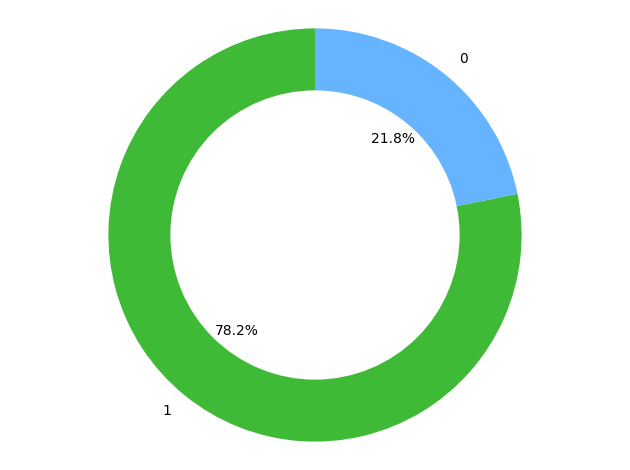

In [45]:
from collections import Counter

# See the data number of sentence in each category
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()


###Preprocessing

In [46]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

In [47]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

##Load the model
Import the model from google drive, and then unzip it

In [48]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/bert_pretrained_model.zip'
# Create a directory to extract the contents
extract_path = '/content/bert_pretrained_model/'
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


###Now loading the model and tokenizer
For tokenizer we should make a dir and upload the vocab.txt we previously achieved, there. I did this manually

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [64]:
from transformers import BertForMaskedLM

# Load the saved BERT model
bert_model = BertModel.from_pretrained(os.path.join("bert_pretrained_model", "final_model"))

Some weights of BertModel were not initialized from the model checkpoint at bert_pretrained_model/final_model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer_output_dir = "bert_tokenizer"
os.mkdir(tokenizer_output_dir)

In [50]:
from transformers import BertTokenizerFast
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_output_dir)

##Classifiers

###Define the classifier

In [51]:
# Define your MLP classifier
import torch.nn as nn

class MLPClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.mlp(x)


In [ ]:
# import torch
# import torch.nn as nn

# # Define your classifier (MLP)
# class MLPClassifier(nn.Module):
#   def __init__(self, input_size: int, output_size: int, hidden_units_list: list):
#     super().__init__()
#     layers = []

#     # Add input layer
#     layers.append(nn.Linear(input_size, hidden_units_list[0]))
#     layers.append(nn.ReLU())
#     layers.append(nn.Dropout(p=0.1))

#     # Add hidden layers
#     for i in range(1, len(hidden_units_list)):
#       layers.append(nn.Linear(hidden_units_list[i - 1], hidden_units_list[i]))
#       layers.append(nn.ReLU())
#       #layers.append(nn.Dropout(p=0.2))

#     # Add output layer
#     layers.append(nn.Linear(hidden_units_list[-1], output_size))

#     self.model = nn.Sequential(*layers)

#   def forward(self, x):
#     return self.model(x)

###Set Parameters and Tokenize Data

In [65]:
# Assuming pooled_representation has been computed
vocab_size = 30522
input_size = 768  # Get the size of the pooled representation
hidden_size = 256  # Adjust as needed
output_size = 1  # Binary classification, 1 output unit
batch_size = 32

# Tokenize train_docs and test_docs using the trained tokenizer
train_tokenized = tokenizer(train_docs.tolist(),max_length=512, truncation=True, padding=True,
                            return_tensors='pt')

test_tokenized = tokenizer(test_docs.tolist(),max_length=512, truncation=True, padding=True,
                           return_tensors='pt')

###Create a custom dataset


In [66]:
from torch.utils.data import DataLoader , Dataset
# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create DataLoader
train_dataset = CustomDataset(train_tokenized, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

###Initialize MLP Classifier and Define Loss Function and Optimizer

In [67]:
# Initialize MLP classifier
hidden_units = 256
learning_rate = 0.001
classifier = MLPClassifier(input_size=input_size, hidden_size=hidden_units, output_size=output_size)

# Move your model and data loaders to the selected device
bert_model.to(device)
classifier.to(device)

# Freeze the BERT model parameters
for param in bert_model.parameters():
    param.requires_grad = False

# BCE loss
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate)

###Training loop

In [ ]:
# Assuming pooled_representation has been computed
input_size = pooled_representation.size(1)  # Get the size of the pooled representation
hidden_size = 256  # Adjust as needed
output_size = 1  # Binary classification, 1 output unit

sentiment_model = SentimentAnalysisModel(input_size, hidden_size, output_size)

# Feed into your neural network
predictions = sentiment_model(pooled_representation)
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
binary_predictions = (predictions > 0.5).float()

In [68]:
for batch in train_loader:
  inputs = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  print("inputs shapes",inputs.shape)
  print("attention_mask shapes",attention_mask.shape)
  print("labels shapes",labels.shape)
  # Forward pass through BERT

  with torch.no_grad():
        bert_outputs = model(input_ids=inputs)
        bert_last_hidden_states = bert_outputs.last_hidden_state
      # Assuming bert_outputs["logits"] is the BERT output tensor
      # pooled_representation = torch.mean(bert_outputs["logits"], dim=1)

  break

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


inputs shapes torch.Size([32, 296])
attention_mask shapes torch.Size([32, 296])
labels shapes torch.Size([32])


In [72]:
bert_last_hidden_states

tensor([[[ 8.6680e-01,  1.3587e+00,  1.2032e+00,  ..., -2.6363e+00,
          -1.4330e-01, -8.1810e-01],
         [-1.0772e+00,  5.1477e-01,  1.1588e+00,  ...,  5.0197e-01,
           1.5700e+00, -2.1158e+00],
         [-2.4233e+00,  5.3829e-01,  7.7183e-01,  ..., -5.3919e-01,
          -4.1958e-01, -1.0043e+00],
         ...,
         [-1.5988e+00,  1.6812e+00,  9.0157e-01,  ..., -1.6605e+00,
           6.0875e-01, -1.3378e+00],
         [-1.0267e+00,  1.3551e+00,  1.2314e+00,  ..., -1.9149e+00,
           6.3703e-01,  1.0335e-01],
         [-1.3734e+00,  8.9450e-01,  2.6826e+00,  ..., -2.2210e+00,
           7.1217e-01, -8.2383e-01]],

        [[ 1.5274e-01,  5.8137e-01,  9.5651e-01,  ..., -1.8281e+00,
          -1.6764e-01, -8.1954e-01],
         [-2.0683e+00,  9.0225e-01,  2.2082e+00,  ..., -9.3039e-01,
           1.8514e+00, -6.3529e-01],
         [-6.5512e-01,  1.4345e+00,  5.6192e-01,  ..., -2.9425e-01,
           2.1427e-01, -1.5626e+00],
         ...,
         [-2.4460e-01,  1

In [ ]:
bert_outputs["hidden_states"]

In [ ]:
outputs.size() , labels.float().unsqueeze(dim =1).size()

(torch.Size([32, 1]), torch.Size([32, 1]))

In [ ]:
epochs = 3
# Training loop
classifier.train()
# set the train loss value
train_loss = 0.0
for epoch in range(epochs):
    for batch in train_loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass through BERT
        with torch.no_grad():
            bert_outputs = bert_model(input_ids=inputs, attention_mask=attention_mask)
            pooled_representation = torch.mean(bert_outputs["logits"], dim=1)


        # Forward pass through MLP classifier
        outputs = classifier(pooled_representation)
        # calculate and accumulate the loss
        loss = criterion(outputs,labels.float().unsqueeze(dim =1))
        train_loss += loss.item()

        # set optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        loss.backward()

        # optimizer step
        optimizer.step()

        # get average loss per batch
        train_loss = train_loss / len(train_loader)
        break
        # # Compute loss and backpropagate
        # loss = criterion(outputs, labels)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()


###Tokenize the dataset and change labels into tensors

In [ ]:
from torch.utils.data import TensorDataset
import torch

# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'], y_train_tensor)
test_dataset = TensorDataset(test_tokenized['input_ids'], test_tokenized['attention_mask'], y_test_tensor)

# Print dimensions and types of the tensors
print("Train Input IDs Shape:", train_tokenized['input_ids'].shape)
print("Train Attention Mask Shape:", train_tokenized['attention_mask'].shape)
print("Train Labels Tensor Shape:", y_train_tensor.shape)

print("\nTest Input IDs Shape:", test_tokenized['input_ids'].shape)
print("Test Attention Mask Shape:", test_tokenized['attention_mask'].shape)
print("Test Labels Tensor Shape:", y_test_tensor.shape)


Train Input IDs Shape: torch.Size([10046, 512])
Train Attention Mask Shape: torch.Size([10046, 512])
Train Labels Tensor Shape: torch.Size([10046])

Test Input IDs Shape: torch.Size([1111, 512])
Test Attention Mask Shape: torch.Size([1111, 512])
Test Labels Tensor Shape: torch.Size([1111])


###Import libraries

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForPreTraining, AdamW
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

###Making a grid
Making a grid to train multiple networks

In [ ]:
param_grid = {
  'hidden_units_list': [[32],[64],[128],[256],[512],
                        [32,16],
                        [64,16],[64,32],
                        [128,16],[128,32],[128,64],
                        [256,16],[256,32],[256,64],[256,128],
                        [512,16],[512,32],[512,64],[512,128],[512,256],
                        [512,256,128],[256,128,64],[128,64,32],[512,128,64],[512,128,32],
                        [256,128,32],[128,32,32],[512,64,32],[256,64,32]
                        ],
  'learning_rate': [0.001, 0.01]
}

###Feed the data to BERT model and get the hidden states

In [ ]:
# Set BERT model to evaluation mode
model.eval()
# Extract input tensors from the BERT model
with torch.no_grad():
    train_outputs = model(**train_tokenized)
    test_outputs = model(**test_tokenized)

In [ ]:
train_bert_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Assuming you want to use the [CLS] token
test_bert_embeddings = test_outputs.last_hidden_state[:, 0, :]

# XLnet pre-training

## Initial imports

In [ ]:
import os
from tokenizers import XLNetWordPieceTokenizer
from transformers import XLNetLMHeadModel, XLNetConfig
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from transformers import TrainerCallback
from torch.utils.data import DataLoader
import torch
import logging

## Importing dataset from huggingface hub

In [ ]:
from datasets import load_dataset

# You should just change this part in order to download your
# parts of corpus.
indices = {
    "train": [5, 1, 2],
    "test": [0, 2]
}

N_FILES = {
    "train": 126,
    "test": 3
}
_BASE_URL = "https://huggingface.co/datasets/SLPL/naab/resolve/main/data/"
data_url = {
    "train": [_BASE_URL + "train-{:05d}-of-{:05d}.txt".format(x, N_FILES["train"]) for x in range(N_FILES["train"])],
    "test": [_BASE_URL + "test-{:05d}-of-{:05d}.txt".format(x, N_FILES["test"]) for x in range(N_FILES["test"])],
}
for index in indices['train']:
    assert index < N_FILES['train']
for index in indices['test']:
    assert index < N_FILES['test']
data_files = {
    "train": [data_url['train'][i] for i in indices['train']],
    "test": [data_url['test'][i] for i in indices['test']]
}
print(data_files)
dataset = load_dataset('text', data_files=data_files, use_auth_token=False)

## Setting paths and file names

In [ ]:
# Set your paths and file names
data_files = ["path/to/your_dataset_file.txt"]
tokenizer_output_dir = "path/to/xlnet_tokenizer"
pretrained_model_output_dir = "path/to/xlnet_pretrained_model"

## Making files for trainging the tokenizer

In [ ]:
# Extract text data from the dataset
texts = dataset['train']['text']  # Assuming you have a 'text' column in your dataset

# Save the text data to a temporary file
temp_file_path = 'temp_dataset_file.txt'
with open(temp_file_path, 'w', encoding='utf-8') as file:
    for text in texts:
        file.write(text + '\n')

# Training a WordPiece Tokenizer
files = [temp_file_path]

## Training a wordPiece Tokenizer

In [ ]:
# Training a WordPiece Tokenizer
files = [temp_file_path]

# Parameters for Tokenizer Training
vocab_size = 30000
min_frequency = 2
max_length = 128
special_tokens = ["<pad>", "<mask>", "<cls>", "<sep>", "<unk>"]

# Initialize the WordPiece tokenizer for XLNet
tokenizer = XLNetWordPieceTokenizer()

# Train the tokenizer
tokenizer.train(
    files=files,
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    show_progress=True,
    special_tokens=special_tokens,
)

# Save the trained tokenizer
tokenizer.save_model(tokenizer_output_dir)

# Save the trained tokenizer
model_path = "pretrained_xlnet_tokenizer"
# make the directory if not already there
if not os.path.isdir(model_path):
    os.mkdir(model_path)

# Save the trained tokenizer
tokenizer.save_model(tokenizer_output_dir)

# Clean up: Remove the temporary file
os.remove(temp_file_path)

## Tokenizing the dataset

In [ ]:
# Load tokenizer after training
tokenizer = XLNetWordPieceTokenizer(f"{tokenizer_output_dir}/vocab.json", f"{tokenizer_output_dir}/merges.txt")

In [ ]:
# Tokenizing the data using dataset.map()
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

## Model Configuration

In [ ]:
# Model Configuration
model_config = XLNetConfig(
    vocab_size=vocab_size,
    d_model=768,  # Adjust as needed
    n_head=12,  # Adjust as needed
    num_layers=12,  # Adjust as needed
    max_position_embeddings=max_length,
)

# Model Initialization
model = XLNetLMHeadModel(config=model_config)

## Data Collator

In [ ]:
# Data Collator for Language Modeling
class CustomDataCollator(DataCollatorForLanguageModeling):
  def collate_batch(self, batch):
    input_ids = torch.stack([torch.tensor(example['input_ids']) for example in batch])
    attention_mask = torch.stack([torch.tensor(example['attention_mask']) for example in batch])
    labels = torch.stack([torch.tensor(example['input_ids']) for example in batch])
    return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'labels': labels
    }


## Callback

In [ ]:
# Define a custom callback for monitoring
class CustomCallback(TrainerCallback):
  def __init__(self):
    super().__init__()

  def on_step_end(self, args, state, control, model, optimizer, scheduler, **kwargs):
    if state.global_step % args.logging_steps == 0:
      logging.info(f"Step {state.global_step}: Loss = {state.log_metrics['loss']}")

## Training Arguments

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir=pretrained_model_output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=1000,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=500,
)

In [ ]:
# Tokenized data for training
train_inputs = {
    "input_ids": tokenized_dataset["input_ids"],
    "attention_mask": tokenized_dataset["attention_mask"],
}

## Trainer Initialazation

In [ ]:
# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_inputs,
    data_collator=CustomDataCollator(tokenizer=tokenizer, mlm=True, mlm_probability=0.15),
    callbacks=[CustomCallback()],
)

In [ ]:
# Train the model
trainer.train()

# Save the final pre-trained model
trainer.save_model(os.path.join(pretrained_model_output_dir, "final_model"))